# Kohonen Networks

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [352]:
def gauss_nhood(x, t=None):
    if t is None:
        t = 1
    return np.exp(-(x * t) ** 2)

def mexican_hat_nhood(x, t=None):
    if t is None:
        t = 1
    return (2 - 4*(x*t) ** 2) * np.exp(-(x * t) ** 2)

def exp_decay(t, lambda_max):
    """ t: current interation """
    return np.exp(-t / lambda_max)

def euclidean_distance(a, b):
    return np.linalg.norm(np.subtract(a, b), ord=2, axis=-1)

def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

In [438]:
class KOH:

    def __init__(self, input_dim, shape, distance_metric=euclidean_distance, decay_function=exp_decay, neighborhood_function=gauss_nhood):
        """
        input_dim: number of input vectors, neuron dim
        shape: tuple (N, M)
        """
        assert len(shape) == 2
        self.input_dim = input_dim
        self.shape = shape
        self.weights = self.random_init()
        self.distance_metric = distance_metric
        self.decay_function = decay_function
        self.neighborhood_function = neighborhood_function
    
    def random_init(self):
        return np.random.standard_normal(
            size=(self.shape[0], self.shape[1], self.input_dim)
        )

    def nhood_weight(self, n1, n2, t=None, r=None):
        """ calculates neighborhood distance """
        if r is None:
            r = 1
        return self.neighborhood_function(self.distance_metric(n1, n2) * r, t)

    def find_bmu(self, x):
        """ finds best matching unit """
        index = np.argmin(self.distance_metric(self.weights, x))
        return np.unravel_index(index, self.shape)
    
    def get_weights(self, indices):
        """ get weights from indices """
        return self.weights[indices[0]][indices[1]]
                    
    def update_weights(self, x, bmu, t, lambda_max, r, use_nhood_decay=False):
        """ updates weights """
        time = None
        if use_nhood_decay:
            time = t
            
        nhood_weights = self.nhood_weight(bmu, self.weights, time, r)
        nhood_weights_tensor = np.stack((nhood_weights, ) * self.input_dim, axis=2)
        
        self.weights = self.weights + exp_decay(t, lambda_max) * nhood_weights_tensor * (x - self.weights)

    def predict(self, data):
        predictions = []
        for x in data:
            predictions.append(np.argmin(self.distance_metric(self.weights, x)))
        return np.array(predictions)
    
    def train(self, data, lambda_max, r=None, use_nhood_decay=False):
        """ 
        lambda_max: number of iterations
        """
        shuffled_data = np.copy(data)
        np.random.shuffle(shuffled_data)
        
        for t in range(1, lambda_max+1):
            for x in shuffled_data:
                bmu_indices = self.find_bmu(x)
                bmu = self.get_weights(bmu_indices)
                self.update_weights(x, bmu, t, lambda_max, r, use_nhood_decay)

### Some tests

In [271]:
from sklearn.metrics import v_measure_score

In [263]:
hexagon = pd.read_csv("dane/hexagon.csv")

In [366]:
hex_train = hexagon[['x', 'y']].to_numpy()

<Axes: >

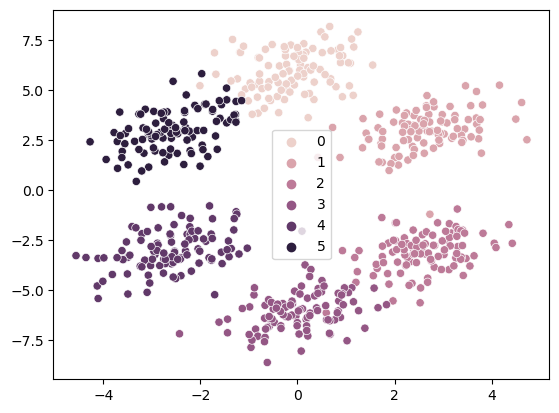

In [265]:
sns.scatterplot(x=hex_train[:,0], y=hex_train[:,1], hue=hexagon['c'].to_numpy())

In [669]:
koh = KOH(2, (30,20))

In [670]:
koh.train(hex_train, lambda_max=10, r=1, use_nhood_decay=False)

In [671]:
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))

clusters: 6
v measure: 0.9222243538465869


<Axes: >

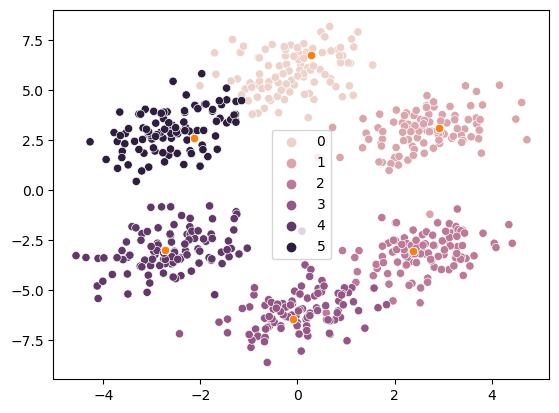

In [672]:
weights_res = koh.weights.reshape(-1, 2)
sns.scatterplot(x=hex_train[:,0], y=hex_train[:,1], hue=hexagon['c'].to_numpy())
sns.scatterplot(x=weights_res[:,0], y=weights_res[:,1])